# Efecto del tiempo en simulación de temperatura

La bibliografía estudiada sugiere que la temperatura debería converger al dejar la fuente encendida por un periodo largo de tiempo. Esto coincide con tanto la teoría física como matemática. En este notebook se buscará evidenciar esta convergencia, para luego apagar la fuente y evidenciar un enfriamiento exponenical.

In [2]:
import sys
sys.path.append('..')

import optimus
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field
from optimus.postprocess.plot import surface_plot

from utilities import finite_difference, rectangular_pulse, turk_pulse

Se usarán los parámetros físicos del paper estudiado, solo que con un tiempo considerablemente mayor.

In [3]:
material_ext = optimus.material.load_material('water')
material_int = optimus.material.load_material('bone (cortical)')
IPP_abs_load = np.loadtxt("HEAD_0198 .txt")

c_0 = material_ext.speed_of_sound
rho_0 = material_ext.density
C_t = material_ext.heat_capacity 
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b 
alpha_0 = material_ext.attenuation_coeff_a 

frequency = 500e3

Nx = 51
Ny = 51
Nz = 101

xmin, xmax, ymin, ymax, zmin, zmax = [-0.03, 0.03, -0.03, 0.03, 0, 0.12]

delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

IPP_abs = IPP_abs_load.reshape(
    IPP_abs_load.shape[0], IPP_abs_load.shape[1] // 51, 51) 

intensity = (IPP_abs)**2 / (2 * c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
heat_deposition = intensity.copy()
heat_deposition = 2 * alpha * intensity

In [4]:
delta_t = 2e-2
Nt = int(4e4)
T_0 = np.zeros_like(heat_deposition) + 37

max_temp = []

prev_temp = T_0

time_domain = np.array(range(Nt)) * delta_t

Nt_heat = int(Nt / 2)
Nt_cold = int(Nt / 2)

In [5]:
%%time
for i in range(Nt_heat):
    max_temp.append(np.max(prev_temp))
    
    prev_temp = finite_difference(temp_grid=prev_temp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=1,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)
    
for i in range(Nt_cold):
    max_temp.append(np.max(prev_temp))
    
    prev_temp = finite_difference(temp_grid=prev_temp, 
                                  heat_deposition=heat_deposition, 
                                  pulse_amplitude=0,
                                  delta_x=delta_x,
                                  delta_y=delta_y,
                                  delta_z=delta_z,
                                  delta_t=delta_t,
                                  initial_temp = 37,
                                  k_t = k_t,
                                  rho_0 = rho_0,
                                  C_t = C_t)

CPU times: user 12min 9s, sys: 0 ns, total: 12min 9s
Wall time: 12min 9s


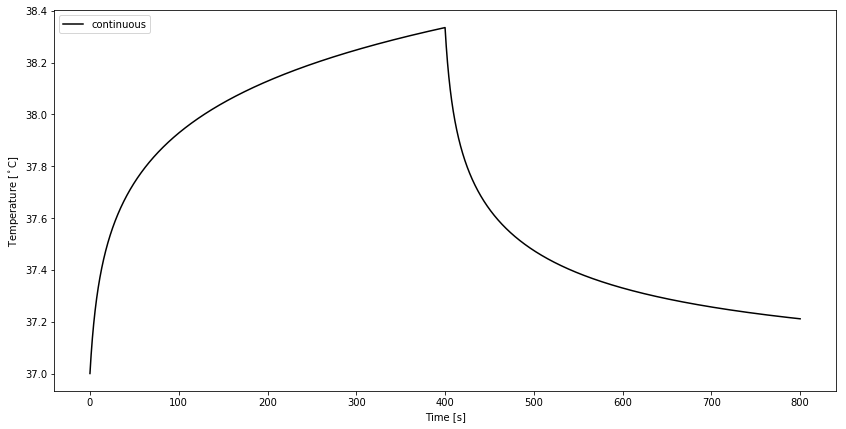

In [6]:
fig = plt.figure(figsize = (14,7))

plt.plot(time_domain, max_temp, c='black', label = 'continuous')

plt.legend(loc = 'upper left')
plt.xlabel('Time [s]')
plt.ylabel('Temperature [$^\circ$C]')
plt.show()

## Comentarios

Se puede ver que tanto el crecimiento como el decaimiento de la simulación de la temperatura siguen las curvas esperadas, con la temperatura convergiendo lentamente alrededor de los 39 grados si se deja correr más tiempo la simulación.